<a href="https://colab.research.google.com/github/skywalker0803r/NLP/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [1]:
!pip install transformers tqdm boto3 requests regex -q

In [2]:
import torch
from transformers import BertTokenizer
from IPython.display import clear_output

In [3]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型
# 取得此預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

clear_output()
print("PyTorch 版本：", torch.__version__)

PyTorch 版本： 1.8.0+cu101


In [4]:
vocab = tokenizer.vocab
print("字典大小：", len(vocab))

字典大小： 21128


# 有 ## 前綴的 tokens 即為 wordpieces。 將本來的 words 拆成更小粒度的 wordpieces

In [5]:
import random
random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids):
    print("{0:15}{1:10}".format(t, id))

token               index          
-------------------------
豚                    6495
獨                    4360
513                 13310
##疸                 17618
祗                    4863
誦                    6301
囫                    1735
skype                9713
##＇                 21076
[unused82]             82


# 利用中文 BERT 的 tokenizer 將一個中文句子斷詞看看

In [6]:
text = "[CLS] 等到潮水 [MASK] 了，就知道誰沒穿褲子。"
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(text)
print(tokens[:10], '...')
print(ids[:10], '...')

[CLS] 等到潮水 [MASK] 了，就知道誰沒穿褲子。
['[CLS]', '等', '到', '潮', '水', '[MASK]', '了', '，', '就', '知'] ...
[101, 5023, 1168, 4060, 3717, 103, 749, 8024, 2218, 4761] ...


# 現在馬上讓我們看看給定上面有 [MASK] 的句子，BERT 會填入什麼字

net forward

In [7]:
from transformers import BertForMaskedLM

tokens_tensor = torch.tensor([ids])  # (1, seq_len)
segments_tensors = torch.zeros_like(tokens_tensor)  # (1, seq_len)
maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)
clear_output()

maskedLM_model.eval()
with torch.no_grad():
    outputs = maskedLM_model(tokens_tensor, segments_tensors)
    predictions = outputs[0]
    # (1, seq_len, num_hidden_units)
del maskedLM_model

Post-processing

In [8]:
# 將 [MASK] 位置的機率分佈取 top k 最有可能的 tokens 出來
masked_index = 5
k = 3
probs, indices = torch.topk(torch.softmax(predictions[0, masked_index], -1), k)
predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())

# 顯示 top k 可能的字。一般我們就是取 top 1 當作預測值
print("輸入 tokens ：", tokens[:10], '...')
print('-' * 50)
for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
    tokens[masked_index] = t
    print("Top {} ({:2}%)：{}".format(i, int(p.item() * 100), tokens[:10]), '...')

輸入 tokens ： ['[CLS]', '等', '到', '潮', '水', '[MASK]', '了', '，', '就', '知'] ...
--------------------------------------------------
Top 1 (67%)：['[CLS]', '等', '到', '潮', '水', '來', '了', '，', '就', '知'] ...
Top 2 (25%)：['[CLS]', '等', '到', '潮', '水', '濕', '了', '，', '就', '知'] ...
Top 3 ( 2%)：['[CLS]', '等', '到', '潮', '水', '過', '了', '，', '就', '知'] ...


* 學會填克漏字讓 BERT 更好地 model 每個詞彙在不同語境下該有的 repr.，而 NSP 任務則能幫助 BERT model 兩個句子之間的關係，這在問答系統 QA、自然語言推論 NLI 或是後面我們會看到的假新聞分類任務都很有幫助。
* 這樣的 word repr. 就是近年十分盛行的 contextual word representation 概念。跟以往沒有蘊含上下文資訊的 Word2Vec、GloVe 等無語境的詞嵌入向量有很大的差異。用稍微學術一點的說法就是：

* Contextual word repr. 讓同 word type 的 word token 在不同語境下有不同的表示方式；而傳統的詞向量無論上下文，都會讓同 type 的 word token 的 repr. 相同。

* 直覺上 contextual word representation 比較能反映人類語言的真實情況，畢竟同個詞彙的含義在不同情境下相異是再正常不過的事情。在不同語境下給同個詞彙相同的 word repr. 這件事情在近年的 NLP 領域裡頭顯得越來越不合理。

* 情境 1：胖虎叫大雄去買漫畫，回來慢了就打他。

* 情境 2：妹妹說胖虎是「胖子」，他聽了很不開心。

很明顯地，在這兩個情境裡頭「他」所代表的語義以及指稱的對象皆不同。如果仍使用沒蘊含上下文 / 語境資訊的詞向量，機器就會很難正確地「解讀」這兩個句子所蘊含的語義了。

現在讓我們跟隨這個 Colab 筆記本安裝 BERT 的視覺化工具 BertViz，看看 BERT 會怎麼處理這兩個情境：

In [9]:
# 安裝 BertViz
import sys
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

# import packages
from transformers import BertTokenizer, BertModel
from bertviz import head_view

In [10]:
# 在 jupyter notebook 裡頭顯示 visualzation 的 helper
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

clear_output()

Setup 以後就能非常輕鬆地將 BERT 內部的注意力機制視覺化出來：

In [11]:
# 記得我們是使用中文 BERT
model_version = 'bert-base-chinese'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

def plot_attention(sentence_a,sentence_b):
  # 得到 tokens 後丟入 BERT 取得 attention
  inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
  # 取得注意力
  token_type_ids = inputs['token_type_ids']
  input_ids = inputs['input_ids']
  attention = model(input_ids, token_type_ids=token_type_ids)[-1]
  input_id_list = input_ids[0].tolist() # Batch index 0
  tokens = tokenizer.convert_ids_to_tokens(input_id_list)
  # 交給 BertViz 視覺化
  call_html()
  head_view(attention, tokens)

In [12]:
# 情境 1 的句子
sentence_a = "胖虎叫大雄去買漫畫，"
sentence_b = "回來慢了就打他。"
plot_attention(sentence_a,sentence_b)

<IPython.core.display.Javascript object>

In [13]:
# 情境 2 的句子
sentence_a = "妹妹說胖虎是「胖子」,"
sentence_b = "他聽了很不開心。"
plot_attention(sentence_a,sentence_b)

<IPython.core.display.Javascript object>

* 假如你仍然似懂非懂，只需記得：
  BERT 是一個強大的語言代表模型，給它一段文本序列，它能回傳一段相同長度且蘊含上下文資訊 word repr. 序列，對下游的 NLP 任務很有幫助。

有了這樣的概念以後，我們接下來要做的事情很簡單，
* 1. 就是將自己感興趣的 NLP 任務的文本丟入 BERT ，為文本裡頭的每個 token 取得有語境的 word repr.
* 2. 以此 repr. 進一步 fine tune 當前任務，取得更好的結果。

# 用 BERT fine tune 下游任務

假新聞分類任務

![img](https://leemeng.tw/images/nlp-kaggle-intro/view-data-on-kaggle.jpg)

給定假新聞 title1，判斷另一新聞 title2 跟 title1 的關係（同意、反對或無關)

fine tune BERT 來解決新的下游任務有 5 個簡單步驟

* 1.準備原始文本數據 網址(https://www.kaggle.com/c/fake-news-pair-classification-challenge/data)
* 2.將原始文本轉換成 BERT 相容的輸入格式
* 3.在 BERT 之上加入新 layer 成下游任務模型
* 4.訓練該下游任務模型
* 5.對新樣本做推論

# 1.準備原始文本數據

In [14]:
import os
import pandas as pd
os.getcwd()

'/content'

In [15]:
train_file_path = '/content/drive/MyDrive/kaggle/fake-news-pair-classification-challenge/train.csv'
test_file_path = '/content/drive/MyDrive/kaggle/fake-news-pair-classification-challenge/test.csv'

# 簡單的數據清理，去除空白標題的 examples
df_train = pd.read_csv(train_file_path)
empty_title = ((df_train['title2_zh'].isnull()) \
               | (df_train['title1_zh'].isnull()) \
               | (df_train['title2_zh'] == '') \
               | (df_train['title2_zh'] == '0'))
df_train = df_train[~empty_title]

# 剔除過長的樣本以避免 BERT 無法將整個輸入序列放入記憶體不多的 GPU
MAX_LENGTH = 30
df_train = df_train[~(df_train.title1_zh.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train[~(df_train.title2_zh.apply(lambda x : len(x)) > MAX_LENGTH)]

# 只用 1% 訓練數據看看 BERT 對少量標註數據有多少幫助
SAMPLE_FRAC = 0.01
df_train = df_train.sample(frac=SAMPLE_FRAC, random_state=9527)

# 去除不必要的欄位並重新命名兩標題的欄位名
df_train = df_train.reset_index()
df_train = df_train.loc[:, ['title1_zh', 'title2_zh', 'label']]
df_train.columns = ['text_a', 'text_b', 'label']

# idempotence, 將處理結果另存成 tsv 供 PyTorch 使用
df_train.to_csv("train.tsv", sep="\t", index=False)

print("訓練樣本數：", len(df_train))
df_train.head()

訓練樣本數： 2657


text_a                          text_b      label
0       苏有朋要结婚了，但网友觉得他还是和林心如比较合适  好闺蜜结婚给不婚族的秦岚扔花球，倒霉的秦岚掉水里笑哭苏有朋！  unrelated
1  爆料李小璐要成前妻了贾乃亮模仿王宝强一步到位、快刀斩乱麻！  李小璐要变前妻了？贾乃亮可能效仿王宝强当机立断，快刀斩乱麻！     agreed
2  为彩礼，母亲把女儿嫁给陌生男子，十年后再见面，母亲湿了眼眶  阿姨，不要彩礼是觉得你家穷，给你台阶下，不要以为我嫁不出去！  unrelated
3         猪油是个宝，一勺猪油等于十副药，先备起来再说  传承千百的猪油为何变得人人唯恐避之不及？揭开猪油的四大谣言！  unrelated
4                  剖析：香椿，为什么会致癌？            香椿含亚硝酸盐多吃会致癌？测完发现是谣言  disagreed

In [16]:
df_train.label.value_counts() / len(df_train)

unrelated    0.679338
agreed       0.294317
disagreed    0.026346
Name: label, dtype: float64

In [17]:
df_test = pd.read_csv(test_file_path)
df_test = df_test.loc[:, ["title1_zh", "title2_zh", "id"]]
df_test.columns = ["text_a", "text_b", "Id"]
df_test.to_csv("test.tsv", sep="\t", index=False)

print("預測樣本數：", len(df_test))
df_test.head()

預測樣本數： 80126


text_a                       text_b      Id
0  萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大  辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？  321187
1              萨达姆被捕后告诫美国的一句话，发人深思    10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国  321190
2    萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗          萨达姆被捕后告诫美国的一句话，发人深思  321189
3              萨达姆被捕后告诫美国的一句话，发人深思  被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！  321193
4              萨达姆被捕后告诫美国的一句话，发人深思         中国川贝枇杷膏在美国受到热捧？纯属谣言！  321191

In [18]:
ratio = len(df_test) / len(df_train)
print("測試集樣本數 / 訓練集樣本數 = {:.1f} 倍".format(ratio))

測試集樣本數 / 訓練集樣本數 = 30.2 倍


# 2. 將原始文本轉換成 BERT 相容的輸入格式

關鍵的就是了解如何讓 BERT 讀取這些數據以做訓練和推論。這時候我們需要了解 BERT 的輸入編碼格式

這步驟是本文的精華所在

![img](https://leemeng.tw/images/bert/practical_bert_encoding_for_pytorch.jpg)

第二條分隔線之上的內容是論文裡展示的例子。
* 1.圖中的每個 Token Embedding 都對應到前面提過的一個 wordpiece，
* 2.Segment Embeddings 則代表不同句子的位置，是學出來的。
* 3.Positional Embeddings 則跟其他 Transformer 架構中出現的位置編碼同出一轍。

實際運用 PyTorch 的 BERT 時最重要的則是在第二條分隔線之下的資訊。我們需要將原始文本轉換成 3 種 id tensors：

* 1.tokens_tensor：代表識別每個 token 的索引值，用 tokenizer 轉換即可
* 2.segments_tensor：用來識別句子界限。第一句為 0，第二句則為 1。另外注意句子間的 [SEP] 為 0
*3 .masks_tensor：用來界定自注意力機制範圍。1 讓 BERT 關注該位置，0 則代表是 padding 不需關注

論文裡的例子並沒有說明 [PAD] token，但實務上每個 batch 裡頭的輸入序列長短不一，為了讓 GPU 平行運算我們需要將 batch 裡的每個輸入序列都補上 zero padding 以保證它們長度一致。另外 masks_tensor 以及 segments_tensor 在 [PAD] 對應位置的值也都是 0，切記切記。

有了這些背景知識以後，要實作一個 Dataset 並將原始文本轉換成 BERT 相容的格式就變得十分容易了：

In [19]:
from torch.utils.data import Dataset
 
    
class FakeNewsDataset(Dataset):
    # 讀取前處理後的 tsv 檔並初始化一些參數
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "test"]  # 一般訓練你會需要 dev set
        self.mode = mode
        # 大數據你會需要用 iterator=True
        self.df = pd.read_csv(mode + ".tsv", sep="\t").fillna("")
        self.len = len(self.df)
        self.label_map = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
        self.tokenizer = tokenizer  # 我們將使用 BERT tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == "test":
            text_a, text_b = self.df.iloc[idx, :2].values
            label_tensor = None
        else:
            text_a, text_b, label = self.df.iloc[idx, :].values
            # 將 label 文字也轉換成索引方便轉換成 tensor
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)
            
        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a + ["[SEP]"]
        len_a = len(word_pieces)
        
        # 第二個句子的 BERT tokens
        tokens_b = self.tokenizer.tokenize(text_b)
        word_pieces += tokens_b + ["[SEP]"]
        len_b = len(word_pieces) - len_a
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        segments_tensor = torch.tensor([0] * len_a + [1] * len_b, 
                                        dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞
trainset = FakeNewsDataset("train", tokenizer=tokenizer)

現在讓我們看看第一個訓練樣本轉換前後的格式差異：

In [20]:
sample_idx = 0

# 將原始文本拿出做比較
text_a, text_b, label = trainset.df.iloc[sample_idx].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""[原始文本]
句子 1：{text_a}
句子 2：{text_b}
分類  ：{label}

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[還原 tokens_tensors]
{combined_text}
""")

[原始文本]
句子 1：苏有朋要结婚了，但网友觉得他还是和林心如比较合适
句子 2：好闺蜜结婚给不婚族的秦岚扔花球，倒霉的秦岚掉水里笑哭苏有朋！
分類  ：unrelated

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：tensor([ 101, 5722, 3300, 3301, 6206, 5310, 2042,  749, 8024,  852, 5381, 1351,
        6230, 2533,  800, 6820, 3221, 1469, 3360, 2552, 1963, 3683, 6772, 1394,
        6844,  102, 1962, 7318, 6057, 5310, 2042, 5314,  679, 2042, 3184, 4638,
        4912, 2269, 2803, 5709, 4413, 8024,  948, 7450, 4638, 4912, 2269, 2957,
        3717, 7027, 5010, 1526, 5722, 3300, 3301, 8013,  102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])

label_tensor   ：2

--------------------

[還原 tokens_tensors]
[CLS]苏有朋要结婚了，但网友觉得他还是和林心如比较合适[SEP]好闺蜜结婚给不婚族的秦岚扔花球，倒霉的秦岚掉水里笑哭苏有朋！[SEP]



# 有了 Dataset 以後，我們還需要一個 DataLoader 來回傳成一個個的 mini-batch。畢竟我們不可能一次把整個數據集塞入 GPU，對吧？

In [21]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 這個函式的輸入 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # zero pad 到同一序列長度
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 64 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

有了可以回傳 mini-batch 的 DataLoader 後，讓我們馬上拿出一個 batch 看看：

In [22]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, \
    masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([64, 63]) 
tensor([[ 101, 5722, 3300,  ...,    0,    0,    0],
        [ 101, 4255, 3160,  ..., 8013,  102,    0],
        [ 101,  711, 2506,  ..., 8013,  102,    0],
        ...,
        [ 101,  671, 2157,  ...,    0,    0,    0],
        [ 101, 1380,  677,  ...,    0,    0,    0],
        [ 101, 2458, 1853,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([64, 63])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([64, 63])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        

建立 BERT 用的 mini-batch 時最需要注意的就是 zero padding 的存在了。你可以發現除了 lable_ids 以外，其他 3 個 tensors 的每個樣本的最後大都為 0，這是因為每個樣本的 tokens 序列基本上長度都會不同，需要補 padding。

到此為止我們已經成功地將原始文本轉換成 BERT 相容的輸入格式了。這節是本篇文章最重要，也最需要花點時間咀嚼的內容。在有這些 tensors 的前提下，要在 BERT 之上訓練我們自己的下游任務完全是一塊蛋糕。

# 3. 在 BERT 之上加入新 layer 成下游任務模型

我從李宏毅教授講解 BERT 的投影片中擷取出原論文提到的 4 種 fine-tuning BERT 情境，並整合了一些有用資訊：

![img](https://leemeng.tw/images/bert/bert_fine_tuning_tasks.jpg)

首先，我們前面一直提到的 fine-tuning BERT 指的是在預訓練完的 BERT 之上加入新的線性分類器（Linear Classifier），並利用下游任務的目標函式從頭訓練分類器並微調 BERT 的參數。這樣做的目的是讓整個模型（BERT + Linear Classifier）能一起最大化當前下游任務的目標。

圖中紅色小字則是該任務類型常被拿來比較的資料集，比方說 MNLI 及 SQuAD v1.1。

不過現在對我們來說最重要的是圖中的藍色字體。多虧了 HuggingFace 團隊，要用 PyTorch fine-tuing BERT 是件非常容易的事情。每個藍色字體都對應到一個可以處理下游任務的模型，而這邊說的模型指的是已訓練的 BERT + Linear Classifier。

按圖索驥，因為假新聞分類是一個成對句子分類任務，自然就對應到上圖的左下角。FINETUNE_TASK 則為 bertForSequenceClassification：

In [23]:
# 載入一個可以做中文多分類任務的模型，n_class = 3
from transformers import BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 3

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

# high-level 顯示此模型裡的 modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=3, bias=True)


沒錯，一行程式碼就初始化了一個可以用 BERT 做文本多分類的模型 model。我也列出了 model 裡頭最 high level 的模組，資料流則從上到下，通過：

* BERT 處理各種 embeddings 的模組
* 在神經機器翻譯就已經看過的 Transformer Encoder
* 一個 pool [CLS] token 在所有層的 repr. 的 BertPooler
* Dropout 層
* 回傳 3 個類別 logits 的線性分類器 classifier

model 預設超參

In [24]:
model.config

BertConfig {
  "_name_or_path": "bert-base-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

目前 PyTorch Hub 上有 8 種模型以及一個 tokenizer 可供使用，依照用途可以分為：

基本款：
* bertModel
* bertTokenizer

預訓練階段
* bertForMaskedLM
* bertForNextSentencePrediction
* bertForPreTraining
* Fine-tuning 階段
* bertForSequenceClassification
* bertForTokenClassification
* bertForQuestionAnswering
* bertForMultipleChoice

有了 model 以及我們在前一節建立的 trainloader，讓我們寫一個簡單函式測試現在 model 在訓練集上的分類準確率：

In [25]:
from torch.nn.functional import softmax

def get_predictions(model, dataloader, compute_acc=False):
    predictions,confidence = None,None
    correct = 0
    total = 0
      
    with torch.no_grad():
        # 遍巡整個資料集
        for data in dataloader:
            # 將所有 tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            logits = softmax(logits,dim=1)
            conf, pred = torch.max(logits.data, 1)
            
            # 用來計算訓練集的分類準確率
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # 將當前 batch 記錄下來
            if predictions is None:
                predictions,confidence = pred,conf
            else:
                predictions,confidence = torch.cat((predictions, pred)),torch.cat((confidence,conf))
    
    if compute_acc:
        acc = correct / total
        return predictions, confidence, acc
    return predictions , confidence
    
# 讓模型跑在 GPU 上並取得訓練集的分類準確率
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
predictions , confidence, acc = get_predictions(model, trainloader, compute_acc=True)
print(predictions.shape,confidence.shape)
print("classification acc:", acc)

device: cuda:0
torch.Size([2657]) torch.Size([2657])
classification acc: 0.5054572826496048


毫不意外，模型裡新加的線性分類器才剛剛被初始化，整個分類模型的表現低於 68 % 的 baseline 是非常正常的。因為模型是隨機初始化的，你的執行結果可能跟我有點差距，但應該不會超過 68 %。



另外我們也可以算算整個分類模型以及裡頭的簡單分類器有多少參數：

In [26]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]
     
model_params = get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個分類模型的參數量：{sum(p.numel() for p in model_params)}
線性分類器的參數量：{sum(p.numel() for p in clf_params)}
""")


整個分類模型的參數量：102269955
線性分類器的參數量：2307



# 4. 訓練該下游任務模型

In [27]:
%%time

# 訓練模式
model.train()

# 使用 Adam Optim 更新整個分類模型的參數
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


EPOCHS = 6  # 幸運數字
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for data in trainloader:
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()


        # 紀錄當前 batch loss
        running_loss += loss.item()
        
    # 計算分類準確率
    _,_, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))

[epoch 1] loss: 28.037, acc: 0.828
[epoch 2] loss: 18.363, acc: 0.852
[epoch 3] loss: 13.764, acc: 0.904
[epoch 4] loss: 9.849, acc: 0.937
[epoch 5] loss: 7.881, acc: 0.907
[epoch 6] loss: 7.838, acc: 0.956
CPU times: user 4min 5s, sys: 3min, total: 7min 6s
Wall time: 7min 6s


我們成功地 Fine-tune BERT 了！

# 5. 對新樣本做推論

In [28]:
%%time
# 建立測試集。這邊我們可以用跟訓練時不同的 batch_size，看你 GPU 多大
testset = FakeNewsDataset("test", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=256, collate_fn=create_mini_batch)

# 用分類模型預測測試集
predictions , confidence = get_predictions(model, testloader)

# 用來將預測的 label id 轉回 label 文字
index_map = {v: k for k, v in testset.label_map.items()}

# 生成 Kaggle 繳交檔案
df = pd.DataFrame({"Category": predictions.tolist()})
df['Category'] = df.Category.apply(lambda x: index_map[x])
df['Confidence'] = confidence.detach().cpu().numpy()
df_pred = pd.concat([testset.df.loc[:, ["Id"]], df.loc[:, ['Category','Confidence']]], axis=1)
df_pred.head()

CPU times: user 6min 29s, sys: 4min 32s, total: 11min 1s
Wall time: 11min 1s


In [31]:
df_pred[df_pred.Category=='agreed'].sample(5)

Id Category  Confidence
7309   328553   agreed    0.775236
55964  387348   agreed    0.940432
12464  333778   agreed    0.546813
55336  386719   agreed    0.948499
28744  350088   agreed    0.928384

In [38]:
df_pred[df_pred.Category=='unrelated'].sample(5)

Id   Category  Confidence
27866  349214  unrelated    0.995498
75210  396643  unrelated    0.983895
30796  352149  unrelated    0.986627
64510  375919  unrelated    0.997106
45318  366679  unrelated    0.878223

In [36]:
df_pred[df_pred.Category=='disagreed'].sample(5)

Id   Category  Confidence
24992  346336  disagreed    0.452909
71089  392510  disagreed    0.357290
70844  392267  disagreed    0.429161
14009  335325  disagreed    0.358140
71064  392488  disagreed    0.421659

將生成的預測結果上傳到 Kaggle 網站，看看會得到怎麼樣的結果：

In [39]:
# 上傳到 Kaggle 網站 不需要 Confidence
df_pred = df_pred.drop('Confidence',axis=1)
df_pred.to_csv('bert_1_prec_training_samples.csv', index=False)
df_pred.head()

Id   Category
0  321187  unrelated
1  321190  unrelated
2  321189  unrelated
3  321193  unrelated
4  321191  unrelated

In [40]:
!ls bert*.csv

bert_1_prec_training_samples.csv


https://www.kaggle.com/c/fake-news-pair-classification-challenge/submit

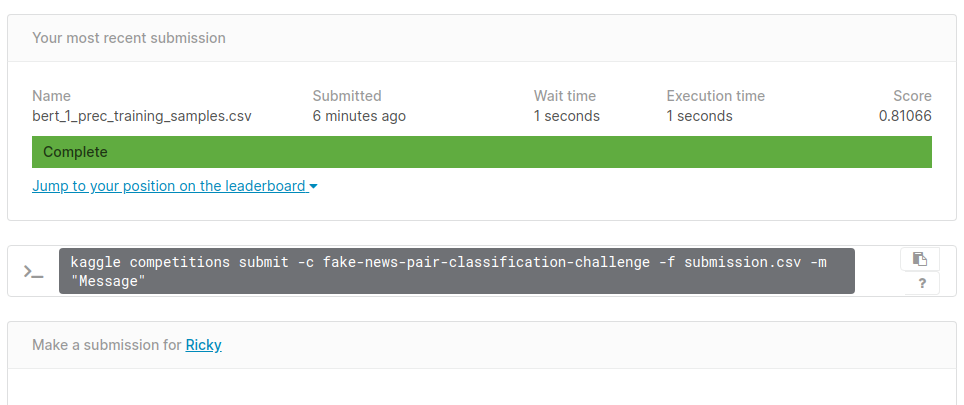

以下程式碼列出模型成功預測 disagreed 類別的一些例子

In [42]:
predictions,confidence = get_predictions(model, trainloader)
df = pd.DataFrame({"predicted": predictions.tolist()})
df['predicted'] = df.predicted.apply(lambda x: index_map[x])
df1 = pd.concat([trainset.df, df.loc[:, 'predicted']], axis=1)
disagreed_tp = ((df1.label == 'disagreed') & \
                (df1.label == df1.predicted) & \
                (df1.text_a.apply(lambda x: True if len(x) < 10 else False)))
df1[disagreed_tp].head()

text_a                     text_b      label  predicted
952    李宇春跟老外结婚  李宇春被传嫁给78岁老外？春爸被逼亲自辟谣：假的！  disagreed  disagreed
1752  海口飞机撒药治白蛾  紧急辟谣 飞机又来撒药治白蛾了？别再传了，是假的！  disagreed  disagreed
2646  12306数据泄漏   铁路12306 辟谣，称网站未发生用户信息泄漏！  disagreed  disagreed

讓我們從中隨意選取一個例子，看看 fine tuned 後的 BERT 能不能關注到該關注的位置。再次出動 BertViz 來視覺化 BERT 的注意權重

In [43]:
model_version = 'bert-base-chinese'
finetuned_model  = BertModel.from_pretrained(model_version, 
                                  output_attentions=True, state_dict=model.state_dict())

# 兩個句子
sentence_a = "烟王褚时健去世"
sentence_b = "辟谣：一代烟王褚时健安好！"

# 得到 tokens 後丟入 BERT 取得 attention
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = finetuned_model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

# 結語

一路過來，你現在應該已經能夠：

* 直觀理解 BERT 內部自注意力機制的物理意義
* 向其他人清楚解釋何謂 BERT 以及其運作的原理
* 了解 contextual word repr. 及兩階段遷移學習
* 將文本數據轉換成 BERT 相容的輸入格式
* 依據下游任務 fine tuning BERT 並進行推論
* 恭喜！你現在已經具備能夠進一步探索最新 NLP 研究與應用的能力了。